In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

# Read in data:
# Cloud_Sections
cloud_sections = pd.read_csv('Cleaned/CLOUD_SECTIONS_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Designed_Pipe_Center
designed_centers = pd.read_csv('Cleaned/DESIGNED_Pipe_Centers_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Planes_Local_Global_Cleaned
p_info = pd.read_csv('Cleaned/Planes_Local_Global_Cleaned.csv', delimiter = ',', encoding = 'latin1')

In [2]:
# A List of sections, where each section is a list of tuples, and each tuple is the XY coordinates of a point on the point cloud
TuplePairsBySection = [] 

# A list of the Designed Center points and radius, each object in the list is a panda dataframe where there are as many rows as pipes
CenterList = [] 

# For n in the number of distinct sections
for n in range(cloud_sections.Section.nunique()): 
    
    # Grabs all dataframe rows in each distinct section
    grab = cloud_sections[cloud_sections['Section'] == 'Section-{' + str(n) + '}'] 
    
    # Adds the individual X and Y points in each point cloud pair for the nth section
    TuplePairsBySection.append(list(zip(grab.X, grab.Y))) 
    
    # Adds the dataframe rows in each distinct section
    CenterList.append(designed_centers[designed_centers['Section'] == 'Section-{' + str(n) + '}']) 

In [3]:
# Arbitrary radius multiplier
N = 1.4

# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesFirstNoiseTestBySection = [] 

# A List of points in the point cloud, by section, that fail the first noise test
FailsFirstNoiseTestBySection = [] 

count = 0 
for section in TuplePairsBySection:
    D, E, F = [], [], []
    
    # Intialize the radius for both pipes
    r1, r2 = CenterList[count].iloc[0,4], CenterList[count].iloc[1,4] 
    
    # Intialize the center XY coordinate tuple for both pipes
    c1, c2 = tuple(CenterList[count].iloc[0,1:3]), tuple(CenterList[count].iloc[1,1:3]) 
    
    for point in section: 
        
        # Test first pipe
        if math.dist(c1, point) < (r1 * N): 
            D.append(point)
            
        # Test second pipe
        elif math.dist(c2, point) < (r2 * N): 
            E.append(point)
        else:
            F.append(point)
            
    PassesFirstNoiseTestBySection.append(D)
    PassesFirstNoiseTestBySection.append(E)
    FailsFirstNoiseTestBySection.append(F)
    count += 1

In [4]:
# Arbitrary IQR multiplier
M = 1.3

def findOutVals(rlist):
    P, F = {}, {}
    P_index = []
    sortedList = sorted(rlist)
    L = len(rlist)
    Q1 = np.median(sortedList[:(L//2 + 2)]) 
    Q3 = np.median(sortedList[(L//2 + 1):])
    IQR = Q3 - Q1
    L_out = Q1 - IQR*M
    R_out = Q3 + IQR*M
    count = 0
    for n in rlist:
        if (n > L_out) and (n < R_out):
            P[count] = n
        count += 1
    for a in P:
        P_index.append(a)
    return P_index

In [5]:
# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesSecondNoiseTestBySection = [] 

# A List of points in the point cloud, by section, that fail the first noise test
FailsSeconNoiseTestBySection = [] 

count = 0 
for circle in PassesFirstNoiseTestBySection:
    passPoints, failPoints = [], []
    if len(circle) == 0:
        count += 1
    else:
        ResList = []
        if count %2 == 0:
            r = CenterList[count // 2].iloc[0,4]
            c = tuple(CenterList[count // 2].iloc[0,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])                 
        else:
            r = CenterList[count // 2].iloc[1,4]
            c = tuple(CenterList[count // 2].iloc[1,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            findOutVals(ResList)
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])
            count += 1       
    PassesSecondNoiseTestBySection.append(passPoints)
    FailsSeconNoiseTestBySection.append(failPoints)

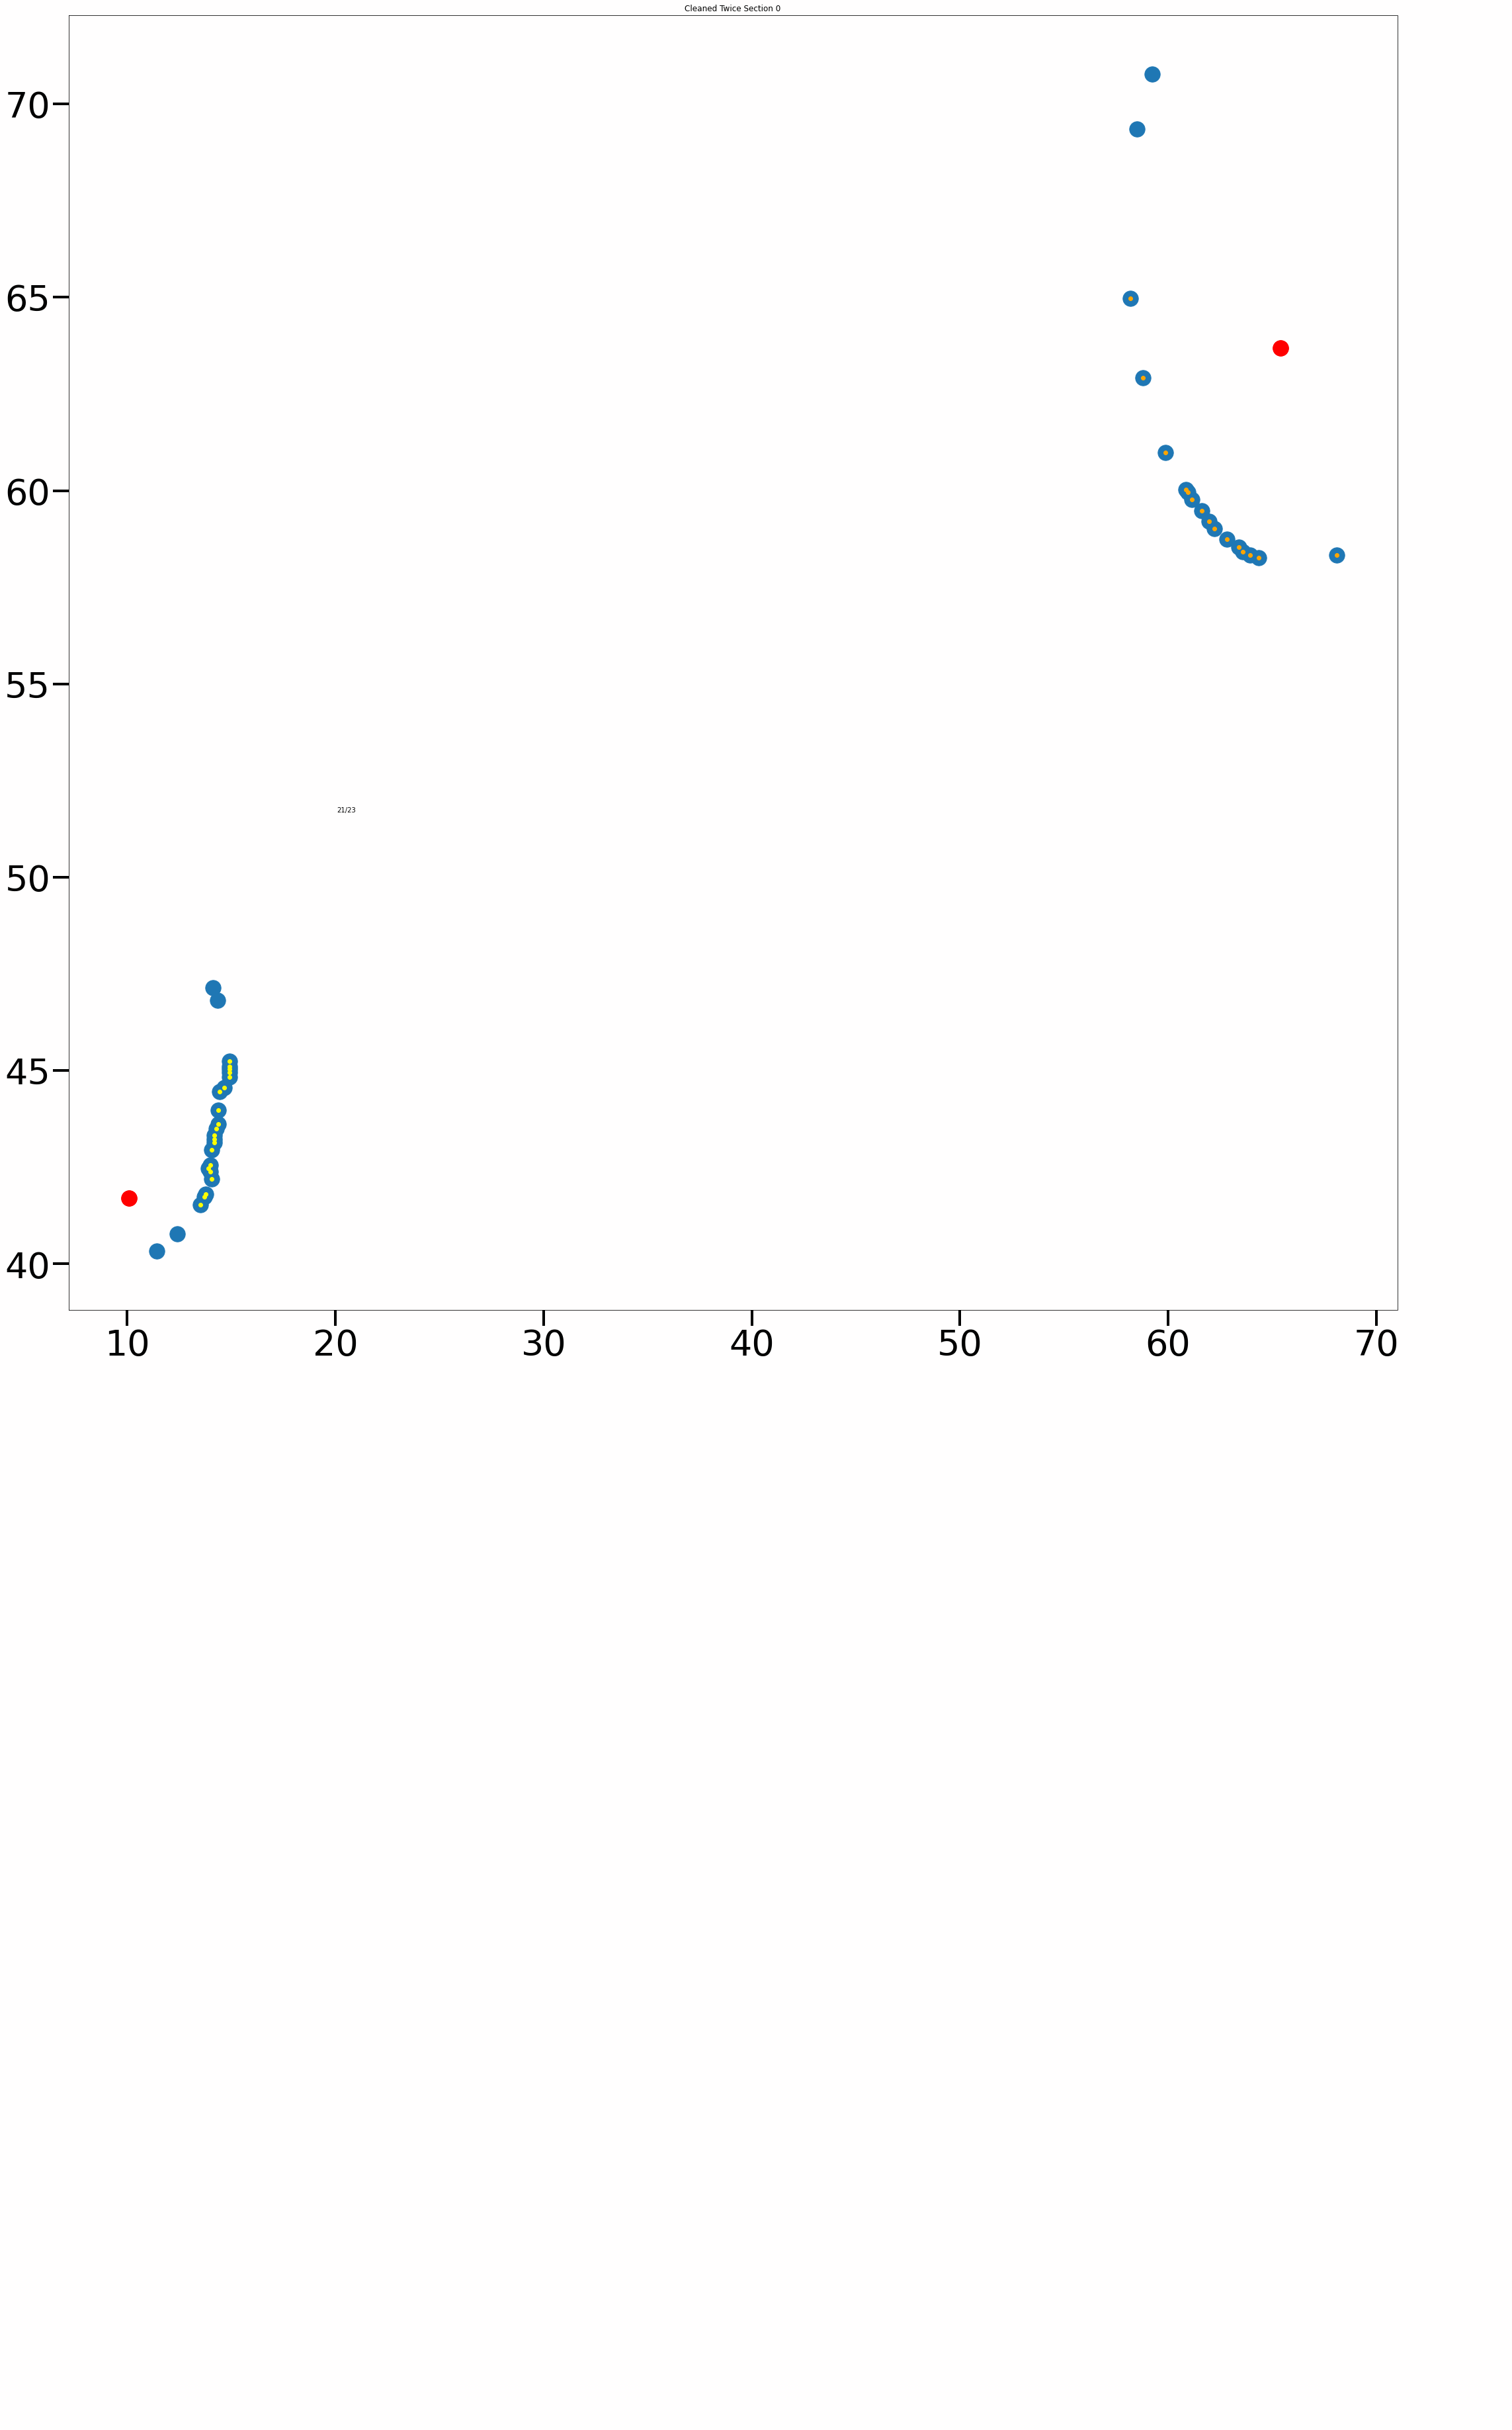

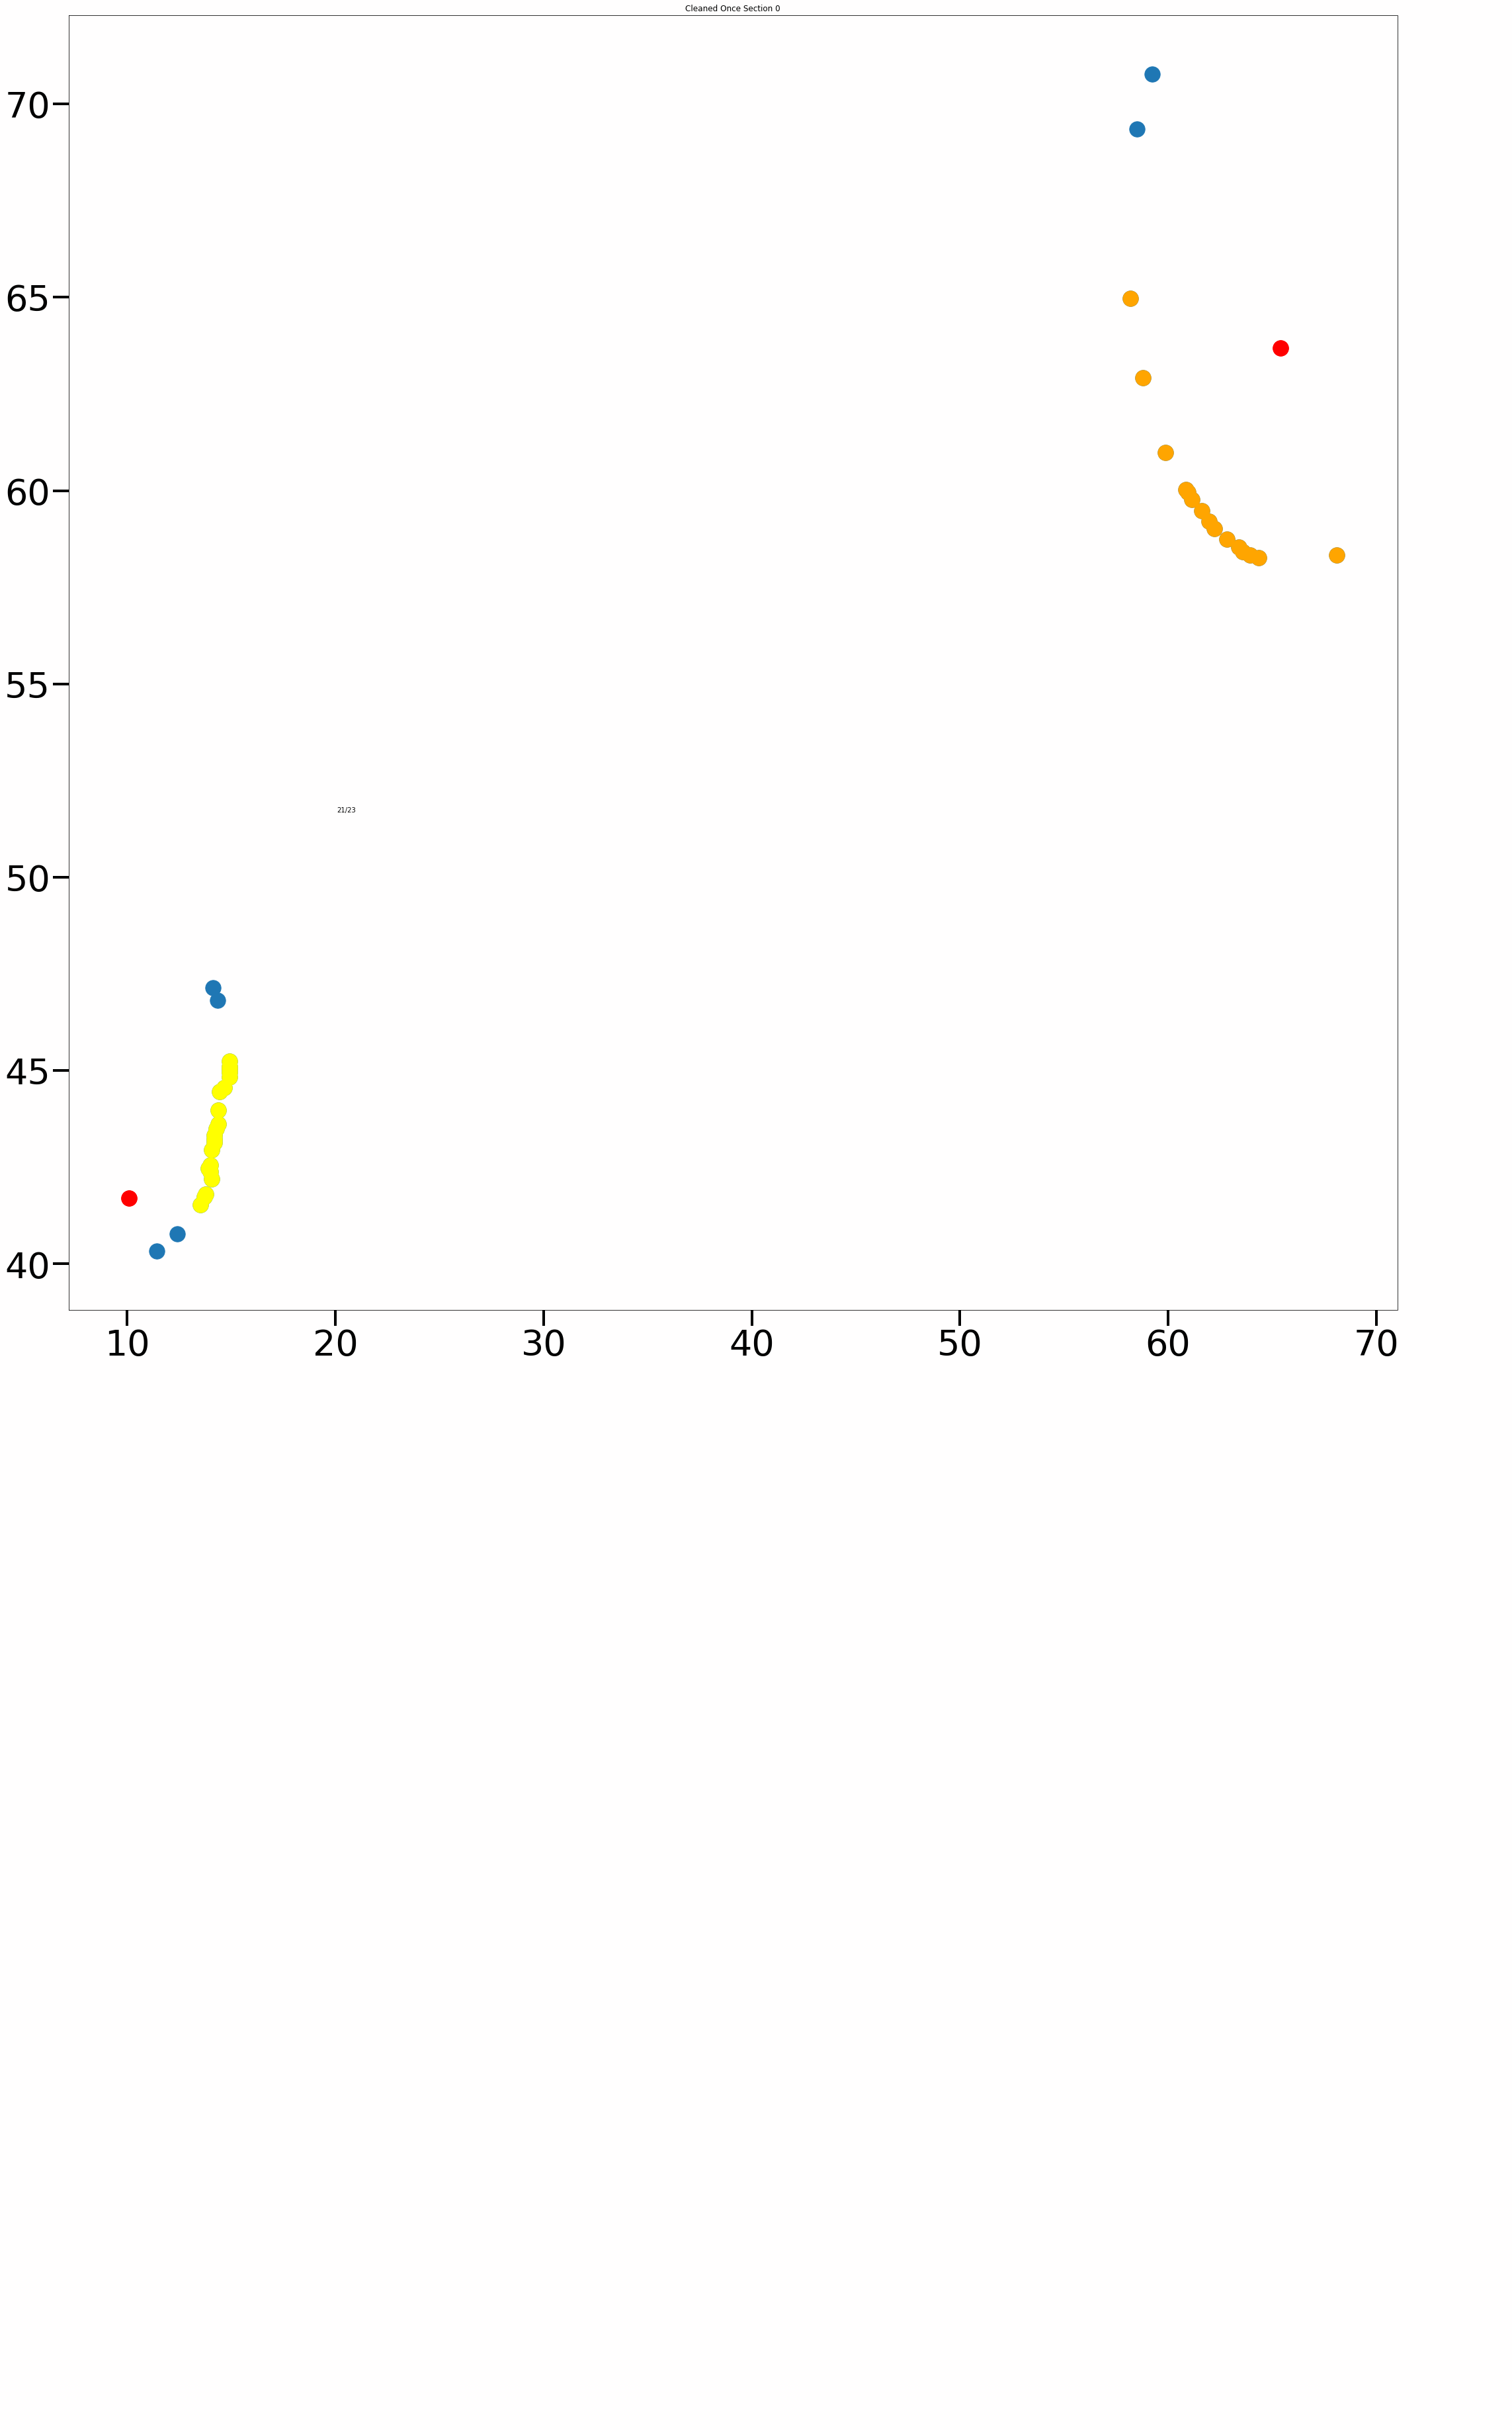

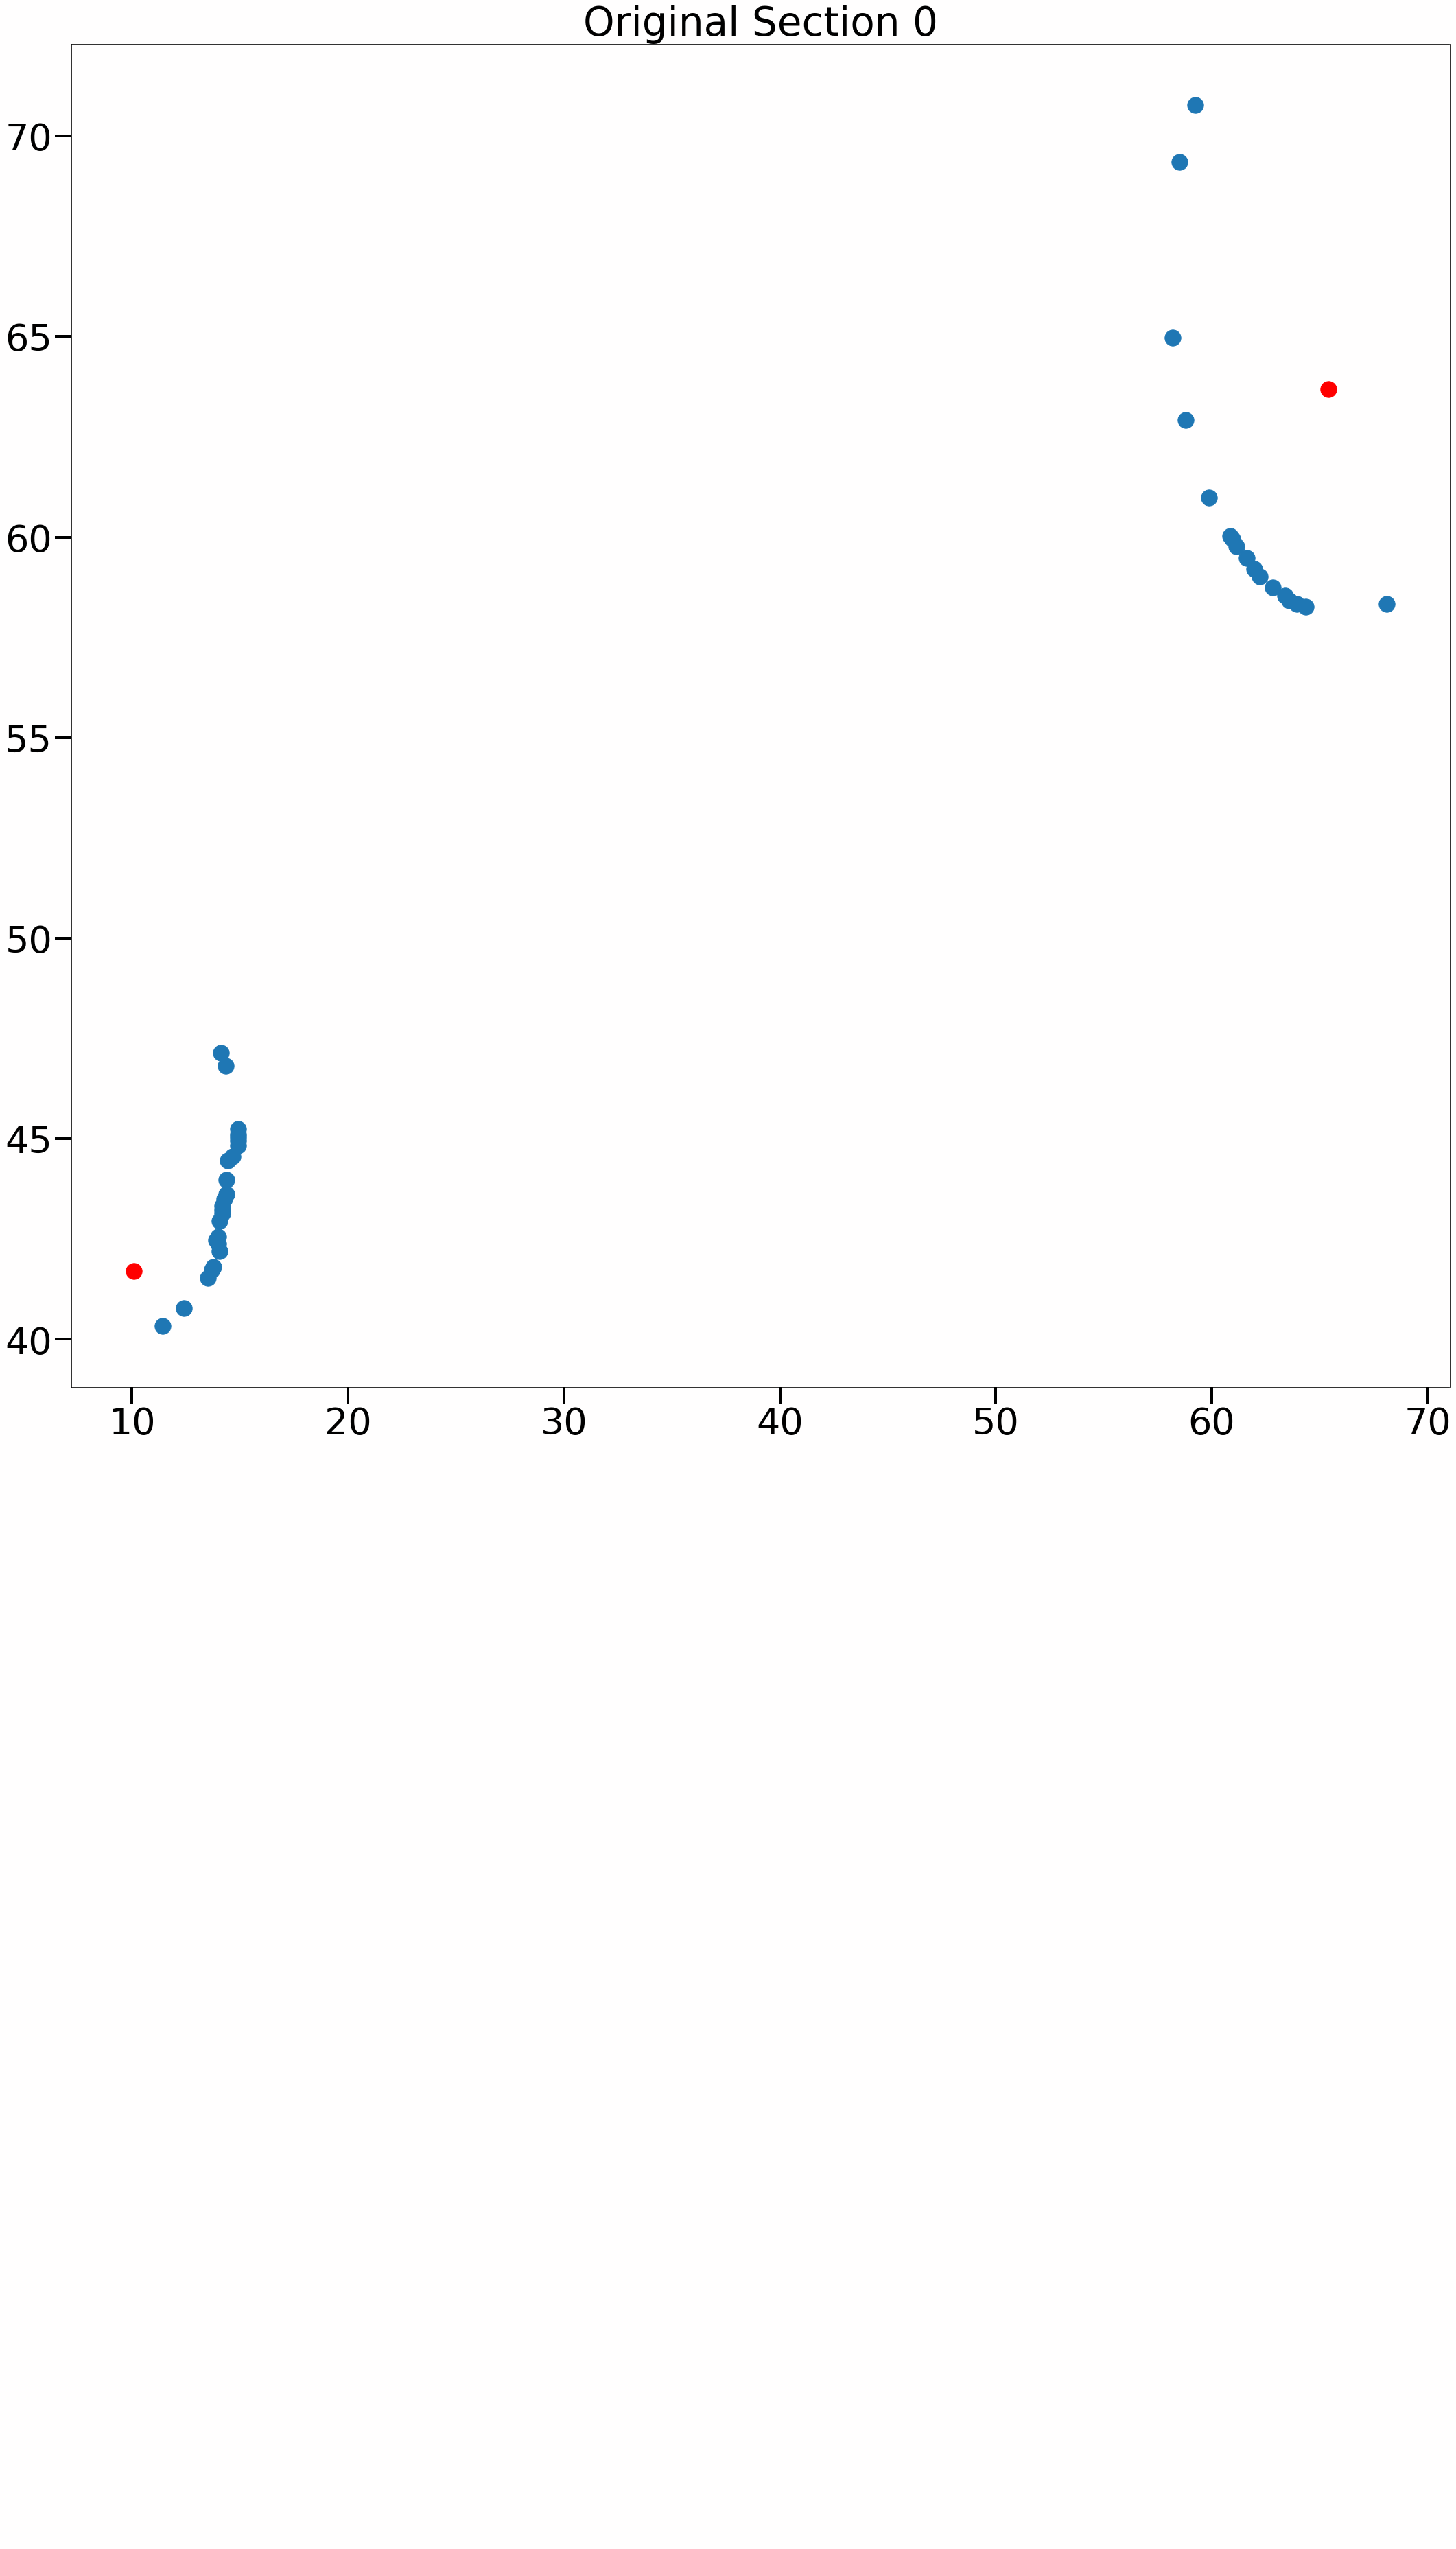

In [9]:
FACECOLOR = '#fffefe'
FIGSIZE = (36,36)
TICK_LABELSIZE = 54
TICK_LENGTH = 24
TICK_WIDTH = 4
TITLE_FONTSIZE = 58
MARKER_SIZE = 544

for NUM in range(1):
    
    # Double cleaned sections---------------------------------------------------
    
    double_clean_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    double_clean_section = double_clean_fig.add_subplot(1,1,1)
    double_clean_section.set_title('Cleaned Twice Section ' + str(NUM))
    double_clean_section.set_facecolor(FACECOLOR)
    double_clean_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    double_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    double_clean_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    double_clean_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: 
        double_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = 'orange') #Circle saved as D
    else: 
        print('Circle ' + str(2 * NUM) + ' from Section ' + str(NUM) + ' has no values.')

    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]))
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: 
        double_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = 'yellow')  #Circle saved as E
    else: 
        print('Circle ' + str(2 * NUM + 1) + ' from Section ' + str(NUM) + ' has no values.')

    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10))
    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10))
    double_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #double_clean_fig.savefig('Results/Cleaned_Twice_Sections/cleaned_twice_section_' + str(NUM) + '.png', facecolor = double_clean_fig.get_facecolor())
    
    # Single cleaned sections---------------------------------------------------
    
    single_clean_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    single_clean_section = single_clean_fig.add_subplot(1,1,1)
    single_clean_section.set_title('Cleaned Once Section ' + str(NUM))
    single_clean_section.set_facecolor(FACECOLOR)
    single_clean_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    single_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    single_clean_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    single_clean_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: 
        single_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = 'orange', s = MARKER_SIZE) #Circle saved as D
    else: 
        print('Circle ' + str(2 * NUM) + ' from Section ' + str(NUM) + ' has no values.')

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]))
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: 
        single_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = 'yellow', s = MARKER_SIZE)  #Circle saved as E
    else: 
        print('Circle ' + str(2 * NUM + 1) + ' from Section ' + str(NUM) + ' has no values.')

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10))

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10))
    single_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #single_clean_fig.savefig('Results/Cleaned_Once_Sections/cleaned_once_section_' + str(NUM) + '.png', facecolor = single_clean_fig.get_facecolor())
    
    # Original Section----------------------------------------------------------
    
    original_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    original_section = original_fig.add_subplot(1,1,1)
    original_section.set_title('Original Section ' + str(NUM), fontsize = TITLE_FONTSIZE)
    original_section.set_facecolor(FACECOLOR)
    original_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    original_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    original_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    original_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    # save final figure
    # Uncomment following line when ready to save images
    
    #original_fig.savefig('Results/Original_Sections/original_section_' + str(NUM) + '.png', facecolor = original_fig.get_facecolor())
    
    # Incase these lines are needed 
    #plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    #plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)